In [2]:
# HIDDEN
import matplotlib
#matplotlib.use('Agg')
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plt.style.use('fivethirtyeight')

In [20]:
# HIDDEN

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

In [30]:
# HIDDEN

def distance(pt1, pt2):
    return np.sqrt(np.sum((pt1 - pt2)**2))

def distance_from_individual(attribute_table, i, p):
    return distance(np.array(attribute_table.row(i)), p)

def table_with_dists(training, p):
    dists = make_array()
    attributes = training.drop('Class')
    for i in np.arange(training.num_rows):
        dists = np.append(dists, distance_from_individual(attributes, i , p))
    return training.with_column('Distance', dists)

def closest(training, p, k):
    with_dists = table_with_dists(training, p)
    sorted_by_dist = with_dists.sort('Distance')
    topk = sorted_by_dist.take(np.arange(k))
    return topk

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [33]:
# HIDDEN

def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

In [21]:
# HIDDEN 
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)

### Training and Testing ###
How good is our nearest neighbor classifier? To answer this we'll need to find out how frequently our classifications are correct. If a patient has chronic kidney disease, how likely is our classifier to pick that up?

If the patient is in our training set, we can find out immediately. We already know what class the patient is in. So we can just compare our prediction and the patient's true class.

But the point of the classifier is to make predictions for *new* patients not in our training set. We don't know what class these patients are in but we can make a prediction based on our classifier. How to find out whether the prediction is correct?

One way is to wait for further medical tests on the patient and then ascertain whether or not our prediction agrees with the test results. But not only does this take time, our classifier is meant to reduce the need for further medical testing. Or at least it is supposed to give the doctor an indication of how to treat the patient until tests can be done.

We need an automated way to estimate the accuracy of our classifier, without actually testing the patient to see if we're right or wrong. In other words, we need to be able to *test* our classifier.

### Overly Optimistic "Testing" ###
To see whether our classification is correct, we need to know the patient's true class. The training set offers a very tempting set of patients on whom to test out our classifier, because we know the class of each patient in the training set.

But let's be careful ... there will be pitfalls ahead if we take this path. An example will show us why.

Suppose we use a 1-nearest neighbor classifier to predict whether a patient has chronic kidney disease, based on glucose and white blood cell count.

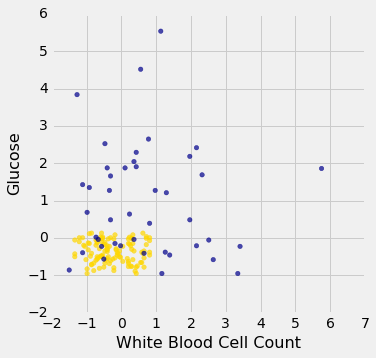

In [22]:
ckd.scatter('White Blood Cell Count', 'Glucose', colors='Color')

We discussed earlier that we expect to get some classifications wrong, because there's some intermingling of blue and gold points in the lower-right.

But what about the points in the training set, that is, the points already on the scatter? Will we ever mis-classify them?

The answer is no. Remember that 1-nearest neighbor classification looks for the point *in the training set* that is nearest to the point being classified. Well, if the point being classified is already in the training set, then its nearest neighbor in the training set is itself! And therefore it will be classified as its own color, which will be correct because each point in the training set is already correctly colored.

In other words, **if we use our training set to "test" our 1-nearest neighbor classifier, the classifier will pass the test 100% of the time.**

Mission accomplished. What a great classifier! 

No, not so much. A new point in the lower-right might easily be mis-classified, as we noted earlier. "100% accuracy" was a nice dream while it lasted.

The lesson of this example is *not* to use the training set to test a classifier that is based on it.

### Generating a Test Set ###
In earlier chapters, when we were estimating numerical parameters based on random sampling, we had to figure out how good our estimates were. To do this, we usually replicated our random sample by bootstrapping. That gave us another sample to compare with the original one.

We will use an analogous idea to test our classifier. We will *create two samples out of the original training set*, use one of the samples as our training set, and *the other one for testing*. 

So we will have three groups of individuals:
- a training set on which we can do any amount of exploration to build our classifier;
- a separate testing set on which to try out our classifier and see what fraction of times it classifies correctly;
- the underlying population of individuals for whom we don't know the true classes; the hope is that our classifier will succeed about as well for these individuals as it did for our testing set.

How to generate the training and testing sets? You've guessed it – we'll select at random.

There are 158 individuals in `ckd`. Let's use a random half of them for training and the other half for testing. To do this, we'll shuffle all the rows, take the first 79 as the training set, and the remaining 79 for testing.

In [69]:
shuffled_ckd = ckd.sample(with_replacement=False)
training = shuffled_ckd.take(np.arange(79))
testing = shuffled_ckd.take(np.arange(79, 158))

Now let's construct our classifier based on the points in the training sample:

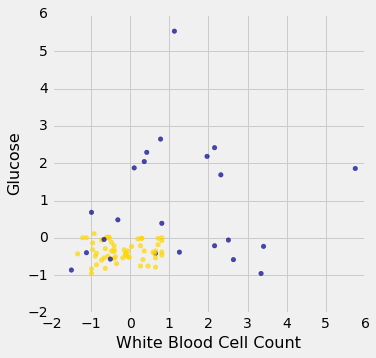

In [70]:
training.scatter('White Blood Cell Count', 'Glucose', colors='Color')
plt.xlim(-2, 6)
plt.ylim(-2, 6);

We get the following classification regsions and decision boundary:

In [72]:
# HIDDEN

x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 6.1, 0.25):
    for y in np.arange(-2, 6.1, 0.25):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
test_grid = Table().with_columns(
    'Glucose', x_array,
    'White Blood Cell Count', y_array
)

In [73]:
# HIDDEN

c = classify_grid(training.drop('Hemoglobin', 'Color'), test_grid, 1)

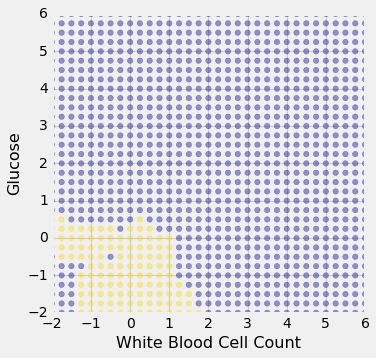

In [74]:
# HIDDEN

test_grid = test_grid.with_column('Class', c).join('Class', color_table)
test_grid.scatter('White Blood Cell Count', 'Glucose', colors='Color', alpha=0.4, s=30)

plt.xlim(-2, 6)
plt.ylim(-2, 6);

Place the *test* data on this graph and you can see at once that while the classifier got almost all the points right, there are some mistakes: for example, blue points of the test set falling in the gold region of the classifier.

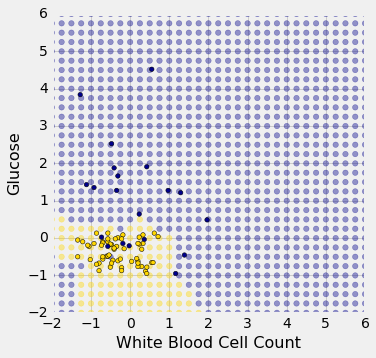

In [75]:
# HIDDEN

test_grid = test_grid.with_column('Class', c).join('Class', color_table)
test_grid.scatter('White Blood Cell Count', 'Glucose', colors='Color', alpha=0.4, s=30)

plt.scatter(testing.column('White Blood Cell Count'), testing.column('Glucose'), c=testing.column('Color'), edgecolor='k')

plt.xlim(-2, 6)
plt.ylim(-2, 6);

Some errors notwithstanding, the classifier does fairly well on the test set. Assuming that the original sample was drawn randomly from the underlying population, the hope is that the classifier will perform with similar accuracy on the overall population, since the test set was chosen randomly from the original sample.

We end this section with a short technical note on working with rows of tables.

### Rows of Tables ###
Until this chapter, we have worked mostly with variables – that is, columns of tables. But now we have to see whether one *individual* is "close" to another. Data for individuals are contained in *rows* of tables.

Here is the original table `ckd` containing data on patients who were tested for chronic kidney disease.

In [6]:
ckd = Table.read_table('ckd.csv')
ckd

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Blood Glucose Random,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1
68,80,1.01,3,2,normal,abnormal,present,present,157,90,4.1,130,6.4,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no,1
61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,148,3.9,135,5.2,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes,1
48,80,1.025,4,0,normal,abnormal,notpresent,notpresent,95,163,7.7,136,3.8,9.8,32,6900,3.4,yes,no,no,good,no,yes,1
69,70,1.01,3,4,normal,abnormal,notpresent,notpresent,264,87,2.7,130,4,12.5,37,9600,4.1,yes,yes,yes,good,yes,no,1
73,70,1.005,0,0,normal,normal,notpresent,notpresent,70,32,0.9,125,4,10,29,18900,3.5,yes,yes,no,good,yes,no,1
73,80,1.02,2,0,abnormal,abnormal,notpresent,notpresent,253,142,4.6,138,5.8,10.5,33,7200,4.3,yes,yes,yes,good,no,no,1
46,60,1.01,1,0,normal,normal,notpresent,notpresent,163,92,3.3,141,4,9.8,28,14600,3.2,yes,yes,no,good,no,no,1


The data corresponding to the first patient is in Row 0 of the table, consistent with Python's indexing system. The Table method `row` accesses the row by taking the index of the row as its argument:

In [7]:
ckd.row(0)

Row(Age=48, Blood Pressure=70, Specific Gravity=1.0049999999999999, Albumin=4, Sugar=0, Red Blood Cells='normal', Pus Cell='abnormal', Pus Cell clumps='present', Bacteria='notpresent', Blood Glucose Random=117, Blood Urea=56, Serum Creatinine=3.7999999999999998, Sodium=111, Potassium=2.5, Hemoglobin=11.199999999999999, Packed Cell Volume=32, White Blood Cell Count=6700, Red Blood Cell Count=3.8999999999999999, Hypertension='yes', Diabetes Mellitus='no', Coronary Artery Disease='no', Appetite='poor', Pedal Edema='yes', Anemia='yes', Class=1)

Rows have their very own data type: they are *row objects*. Notice how the display shows not only the values in the row but also the labels of the corresponding columns.

Rows are in general **not arrays**, as their elements can be of different types. For example, some of the elements of the row above are categorical and some are numerical. So the row can't be converted into an array.

However, you can use `item` as with arrays, to access a particular element of the row. For example, to access the Albumin level of Patient 0, you just have to look at the column labels and note that it's item 3 of the row:

In [8]:
ckd.row(0).item(3)

4

### Converting Rows to Arrays (When Possible) ###
Some datasets are entirely of one type, frequently numerical. The table `wine` contains the chemical composition of 178 different Italian wines. The `Class` column is the cultivar (that is, the grape species).

In [3]:
wine = Table.read_table('wine.csv')

In [10]:
wine

Class,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diulted wines,Proline
1,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.2,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.4,1050
1,13.16,2.36,2.67,18.6,101,2.8,3.24,0.3,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.5,16.8,113,3.85,3.49,0.24,2.18,7.8,0.86,3.45,1480
1,13.24,2.59,2.87,21,118,2.8,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.2,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
1,14.39,1.87,2.45,14.6,96,2.5,2.52,0.3,1.98,5.25,1.02,3.58,1290
1,14.06,2.15,2.61,17.6,121,2.6,2.51,0.31,1.25,5.05,1.06,3.58,1295
1,14.83,1.64,2.17,14,97,2.8,2.98,0.29,1.98,5.2,1.08,2.85,1045
1,13.86,1.35,2.27,16,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


Because the rows consist only of numerical values, it is possible to convert them to arrays using the function `np.array`. Our old friend `make_array` doesn't work on rows.

In [18]:
np.array(wine.row(0))

array([  1.00000000e+00,   1.42300000e+01,   1.71000000e+00,
         2.43000000e+00,   1.56000000e+01,   1.27000000e+02,
         2.80000000e+00,   3.06000000e+00,   2.80000000e-01,
         2.29000000e+00,   5.64000000e+00,   1.04000000e+00,
         3.92000000e+00,   1.06500000e+03])

In the next section, we will define a *distance between rows*, to see how close or how far one individual is from another. Converting rows to arrays will be very handy for that purpose.